# 🪴 01_resize.ipynb  
### Redimensionamiento de imágenes del dataset de hojas de papa

Este notebook redimensiona todas las imágenes del dataset a un tamaño uniforme (por defecto **224×224 px**)  
y las guarda en la carpeta `data/2_data_resize/`, **manteniendo la estructura de clases original**.

Esto garantiza que las imágenes sean consistentes para la posterior extracción de características  
(color, textura, morfología o redes neuronales).


In [1]:
import os
import cv2
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import random

In [4]:
input_dir = Path("../data/1_data_original")          # Carpeta original con el dataset
output_dir = Path("../data/2_data_resize") # Carpeta destino para las imágenes redimensionadas

target_size = (224, 224)  # tamaño final (ancho, alto)
valid_exts = (".jpg", ".jpeg", ".png", ".bmp")

# Crear la carpeta de salida si no existe
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Carpeta origen: {input_dir}")
print(f"Carpeta destino: {output_dir}")
print(f"Tamaño objetivo: {target_size}")

Carpeta origen: ..\data\1_data_original
Carpeta destino: ..\data\2_data_resize
Tamaño objetivo: (224, 224)


In [5]:
for class_folder in sorted(os.listdir(input_dir)):
    class_path = input_dir / class_folder
    if not class_path.is_dir():
        continue  # saltar si no es una carpeta de clase

    # Crear carpeta correspondiente en la salida
    (output_dir / class_folder).mkdir(parents=True, exist_ok=True)

    # Procesar imágenes dentro de la clase
    for img_file in tqdm(os.listdir(class_path), desc=f"Procesando {class_folder}"):
        if not img_file.lower().endswith(valid_exts):
            continue

        img_path = class_path / img_file
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"No se pudo leer {img_path}")
            continue

        # Redimensionar imagen
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # Guardar imagen redimensionada
        out_path = output_dir / class_folder / img_file
        cv2.imwrite(str(out_path), resized)

print("Redimensionamiento completado.")


Procesando Virus: 100%|██████████| 532/532 [00:11<00:00, 44.48it/s]

Redimensionamiento completado.


### 🔍 Verificación visual de resultados

Seleccionaremos una imagen al azar para comparar **antes y después del redimensionamiento**.
Esto permite confirmar que no se haya perdido información relevante visualmente.


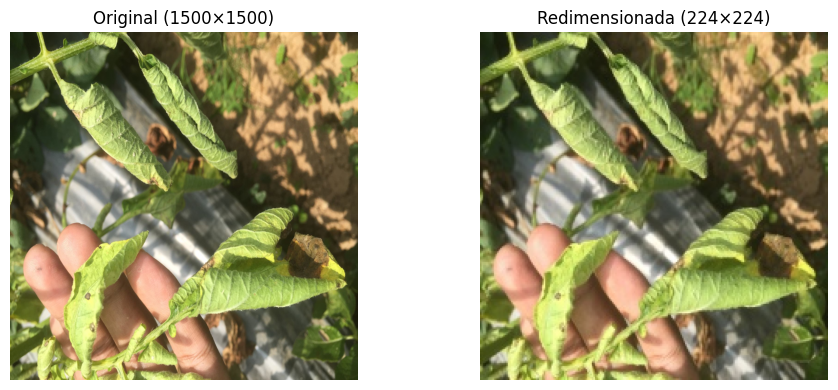

In [8]:
# Seleccionar una clase y una imagen de prueba
sample_class = random.choice(os.listdir(input_dir))
sample_file = random.choice(os.listdir(input_dir / sample_class))

orig_path = input_dir / sample_class / sample_file
resized_path = output_dir / sample_class / sample_file

# Leer ambas imágenes
orig = cv2.cvtColor(cv2.imread(str(orig_path)), cv2.COLOR_BGR2RGB)
resized = cv2.cvtColor(cv2.imread(str(resized_path)), cv2.COLOR_BGR2RGB)

# Mostrar comparación
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.title(f"Original ({orig.shape[1]}×{orig.shape[0]})")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(resized)
plt.title(f"Redimensionada ({target_size[0]}×{target_size[1]})")
plt.axis('off')

plt.tight_layout()
plt.show()
